<a href="https://colab.research.google.com/github/mirpouya/Transformers-in-Computer-Vision/blob/main/Fine_Tuning_ViT_models_HuggingFace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import random

import torch

In [2]:
%%capture
!pip install transformers
# !pip install datasets transformers

In [3]:
!pip install datasets transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.3 MB/s eta 0:00:00


In [4]:
from datasets import load_dataset

In [5]:
cifar10_dataset = load_dataset("cifar10")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [6]:
cifar10_dataset

DatasetDict({
    train: Dataset({
        features: ['img', 'label'],
        num_rows: 50000
    })
    test: Dataset({
        features: ['img', 'label'],
        num_rows: 10000
    })
})

In [7]:
cifar10_dataset["train"][10]

{'img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32>,
 'label': 5}

In [8]:
sample_img = cifar10_dataset["train"][101]['img']
sample_label = cifar10_dataset["train"][101]['label']

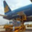

In [9]:
sample_img

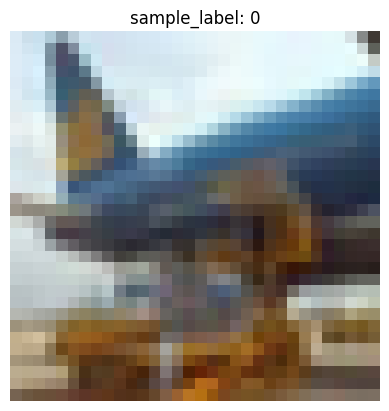

In [10]:
plt.imshow(sample_img)
plt.axis("off")
plt.title(f"sample_label: {sample_label}")
plt.show()

In [11]:
type(cifar10_dataset["train"])

datasets.arrow_dataset.Dataset

In [12]:
cifar10_dataset["train"].features

{'img': Image(decode=True, id=None),
 'label': ClassLabel(names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'], id=None)}

In [13]:
class_labels = cifar10_dataset["train"].features["label"].names

In [14]:
class_labels

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [15]:
cifar10_dataset["test"].features["label"].names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [16]:
labels = cifar10_dataset['train'].features["label"]
labels

ClassLabel(names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'], id=None)

In [17]:
labels.int2str(cifar10_dataset["train"][101]['label'])

'airplane'

<h2> displaying a random set of images in the dataset </h2>

In [18]:
# showing 3 sample of each class in the dataset

def show_train_samples(dataset, n_ex_perclass: int=3, size=(350, 350), seed: int=321):

  # each image size
  w, h = size
  labels_list = dataset["train"].features["label"].names
  # making a grid
  grid = Image.new("RGB", size=(w * n_ex_perclass, h * len(labels_list)))
  # drawing the grid
  draw = ImageDraw.Draw(grid)
  # setting the font
  font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf", 24)

  for label_id, label in enumerate(labels_list):
    # filter the dataset by a specific dataset, shuggle it, pick n_ex_perclass samples from
    single_class_ds = dataset["train"].filter(lambda imgs: imgs["label"] == label_id).shuffle(seed).select(range(n_ex_perclass))

    # plot these samples along a row of grid
    for i, sample in enumerate(single_class_ds):
      image = sample["img"]
      idx = label_id * n_ex_perclass + i
      box = (idx % n_ex_perclass * w, idx // n_ex_perclass * h)
      grid.paste(image.resize(size), box)
      draw.text(box, label, (255, 255, 255), font=font)

  return grid

Filter:   0%|          | 0/50000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/50000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/50000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/50000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/50000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/50000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/50000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/50000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/50000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/50000 [00:00<?, ? examples/s]

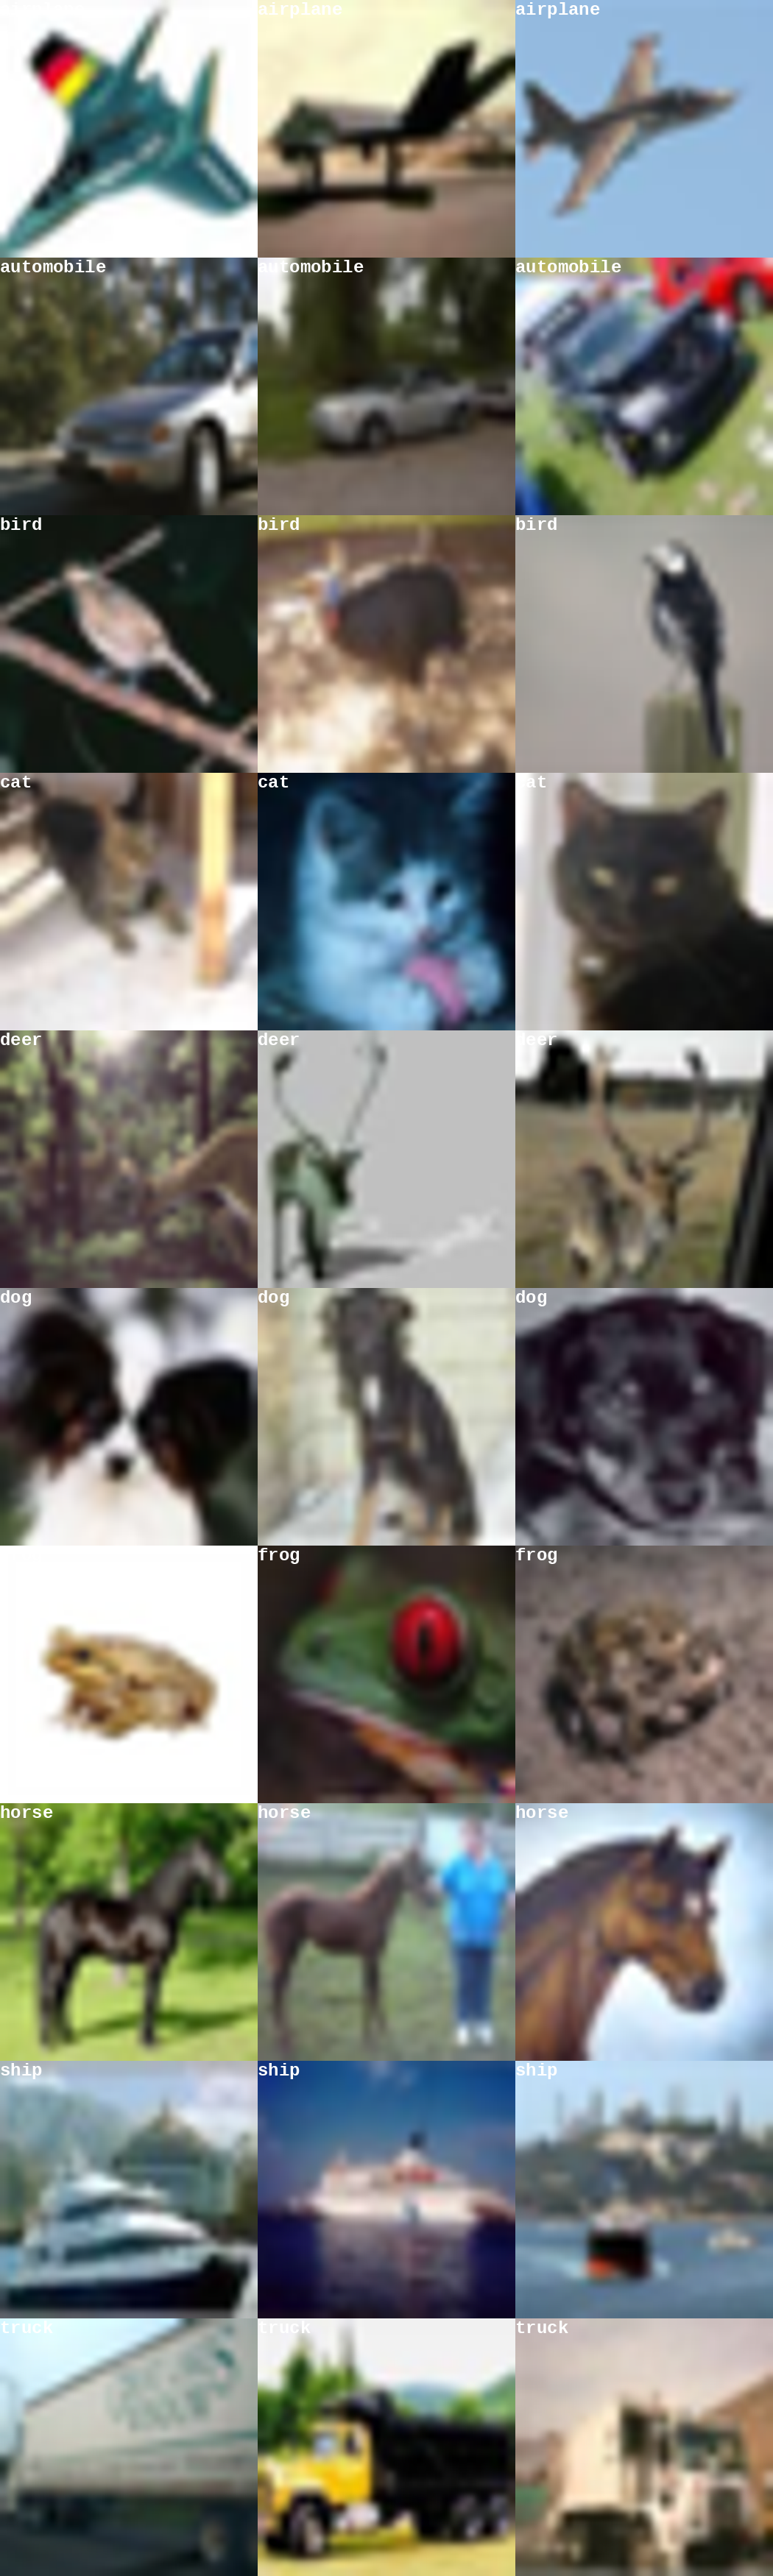

In [19]:
show_train_samples(cifar10_dataset)

In [20]:
def show_test_samples(dataset, seed: int = 1234, examples_per_class: int = 3, size=(350, 350)):

    w, h = size
    labels = dataset['test'].features['label'].names
    grid = Image.new('RGB', size=(examples_per_class * w, len(labels) * h))
    draw = ImageDraw.Draw(grid)
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf", 24)

    for label_id, label in enumerate(labels):

        # Filter the dataset by a single label, shuffle it, and grab a few samples
        ds_slice = dataset['test'].filter(lambda ex: ex['label'] == label_id).shuffle(seed).select(range(examples_per_class))

        # Plot this label's examples along a row
        for i, example in enumerate(ds_slice):
            image = example['img']
            idx = examples_per_class * label_id + i
            box = (idx % examples_per_class * w, idx // examples_per_class * h)
            grid.paste(image.resize(size), box=box)
            draw.text(box, label, (255, 255, 255), font=font)

    return grid

Filter:   0%|          | 0/10000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/10000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/10000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/10000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/10000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/10000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/10000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/10000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/10000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/10000 [00:00<?, ? examples/s]

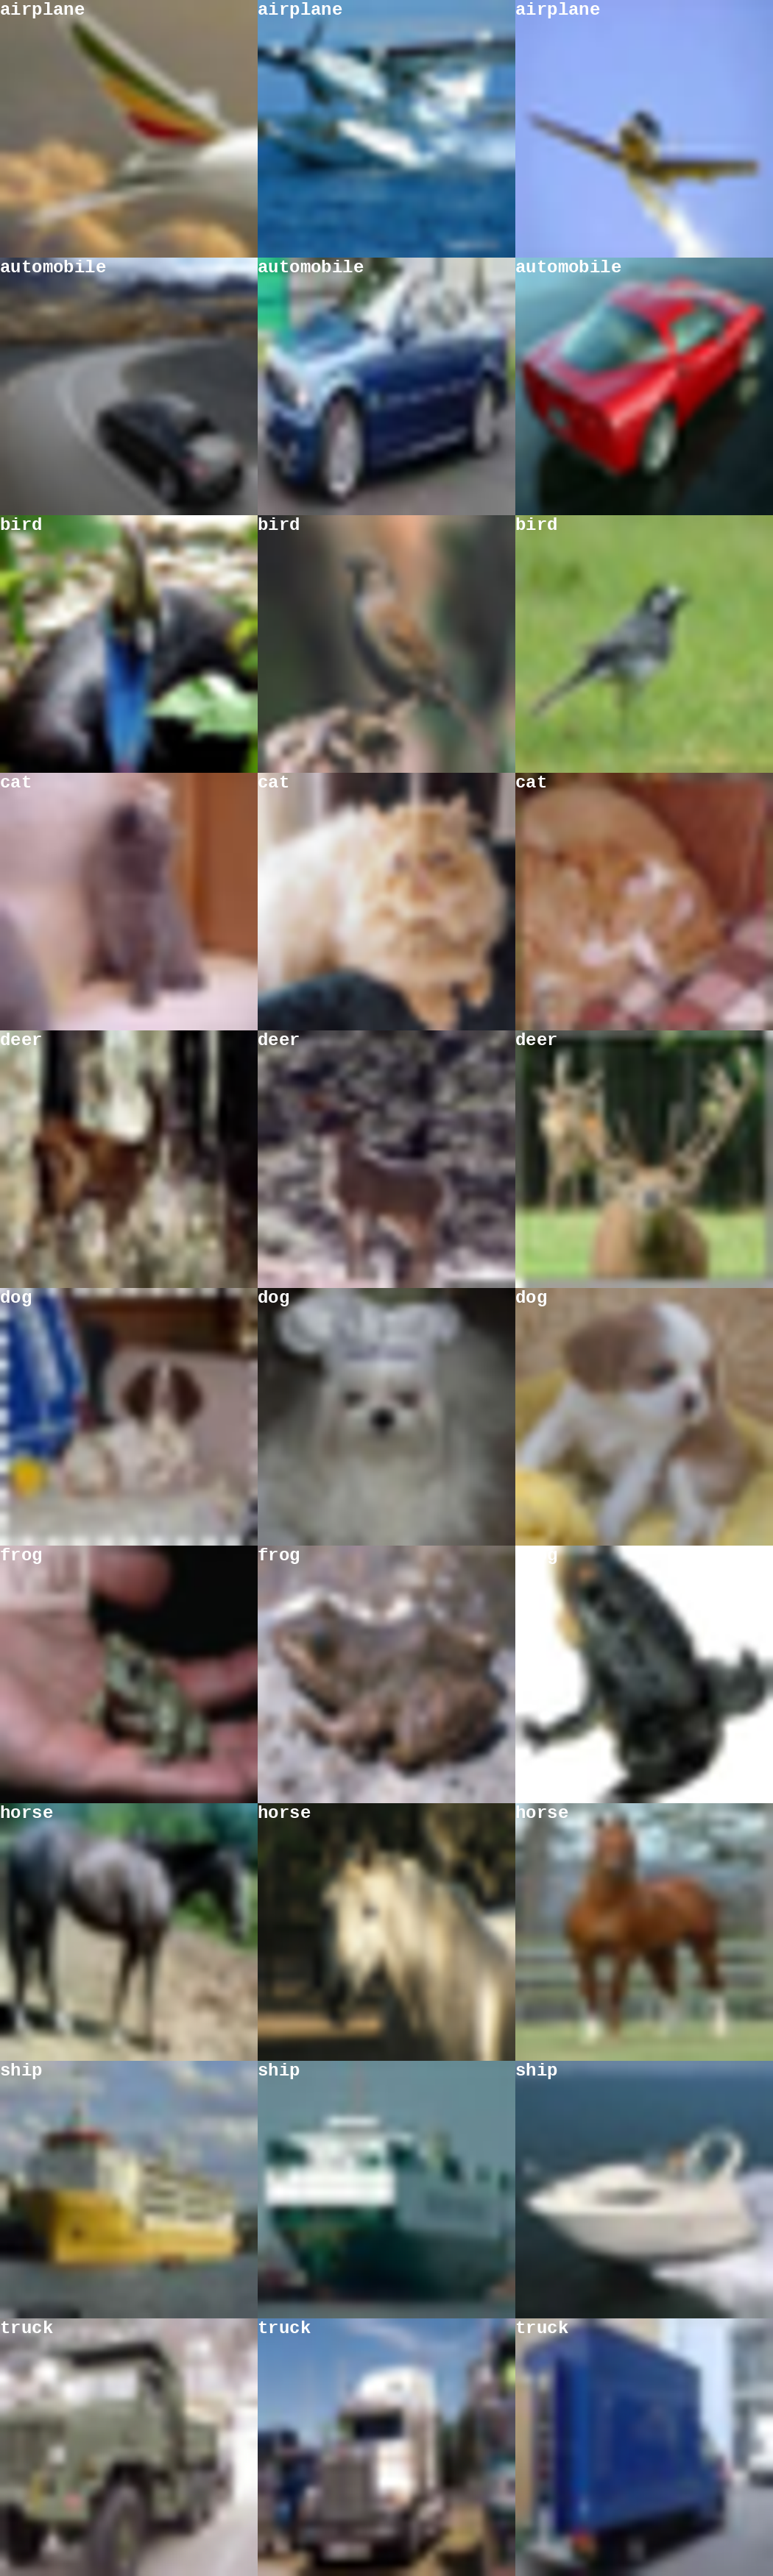

In [21]:
show_test_samples(cifar10_dataset)

<h2> <b> Loading ViT model </b> </h2>

In [22]:
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 5.7 MB/s eta 0:00:00


In [23]:
from transformers import ViTImageProcessor

In [24]:
model_name_or_path = "google/vit-base-patch16-224-in21k"
image_processor = ViTImageProcessor.from_pretrained(model_name_or_path)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [25]:
# seeing configurations
image_processor

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

processing an image, simply passing the image into the processor

In [26]:
rand_indx = random.randint(0, len(cifar10_dataset["train"]))
rand_indx

5409

In [27]:
samp_img = cifar10_dataset["train"][rand_indx]["img"]

Text(0.5, 1.0, 'dog')

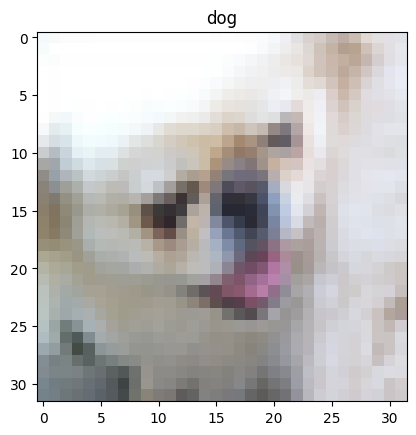

In [28]:
plt.imshow(samp_img)
plt.title(class_labels[cifar10_dataset["train"][rand_indx]["label"]])

In [29]:
image_processor(samp_img)

{'pixel_values': [array([[[ 0.9137255 ,  0.9137255 ,  0.9137255 , ...,  0.77254903,
          0.77254903,  0.77254903],
        [ 0.9137255 ,  0.9137255 ,  0.9137255 , ...,  0.77254903,
          0.77254903,  0.77254903],
        [ 0.9137255 ,  0.9137255 ,  0.9137255 , ...,  0.77254903,
          0.77254903,  0.77254903],
        ...,
        [-0.09019607, -0.09019607, -0.09019607, ...,  0.6156863 ,
          0.6156863 ,  0.6156863 ],
        [-0.09019607, -0.09019607, -0.09019607, ...,  0.6156863 ,
          0.6156863 ,  0.6156863 ],
        [-0.09019607, -0.09019607, -0.09019607, ...,  0.6156863 ,
          0.6156863 ,  0.6156863 ]],

       [[ 0.9607843 ,  0.9607843 ,  0.9607843 , ...,  0.77254903,
          0.77254903,  0.77254903],
        [ 0.9607843 ,  0.9607843 ,  0.9607843 , ...,  0.77254903,
          0.77254903,  0.77254903],
        [ 0.9607843 ,  0.9607843 ,  0.9607843 , ...,  0.77254903,
          0.77254903,  0.77254903],
        ...,
        [ 0.0196079 ,  0.0196079 ,  

In [30]:
image_processor(samp_img)["pixel_values"][0].shape

(3, 224, 224)

<h2> Processing the data </h2>

In [31]:
def img_process_func(image):
  processed_img = image_processor(image["img"], return_tensors="pt")
  processed_img["label"] = image["label"]
  return processed_img

In [32]:
img_process_func(cifar10_dataset["train"][0])

{'pixel_values': tensor([[[[ 0.3961,  0.3961,  0.3961,  ...,  0.2941,  0.2941,  0.2941],
          [ 0.3961,  0.3961,  0.3961,  ...,  0.2941,  0.2941,  0.2941],
          [ 0.3961,  0.3961,  0.3961,  ...,  0.2941,  0.2941,  0.2941],
          ...,
          [-0.1922, -0.1922, -0.1922,  ..., -0.2863, -0.2863, -0.2863],
          [-0.1922, -0.1922, -0.1922,  ..., -0.2863, -0.2863, -0.2863],
          [-0.1922, -0.1922, -0.1922,  ..., -0.2863, -0.2863, -0.2863]],

         [[ 0.3804,  0.3804,  0.3804,  ...,  0.2784,  0.2784,  0.2784],
          [ 0.3804,  0.3804,  0.3804,  ...,  0.2784,  0.2784,  0.2784],
          [ 0.3804,  0.3804,  0.3804,  ...,  0.2784,  0.2784,  0.2784],
          ...,
          [-0.2471, -0.2471, -0.2471,  ..., -0.3412, -0.3412, -0.3412],
          [-0.2471, -0.2471, -0.2471,  ..., -0.3412, -0.3412, -0.3412],
          [-0.2471, -0.2471, -0.2471,  ..., -0.3412, -0.3412, -0.3412]],

         [[ 0.4824,  0.4824,  0.4824,  ...,  0.3647,  0.3647,  0.3647],
          [ 0

Even though it is possible to call this function as a mapping in all the dataset, it will be very slow and inefficient. It is better to transform the image indexes as we needed them, for example transform each batch at the time we needed to feed them to the model.

In [33]:
def transform(image_batch):
  transformed = image_processor([img for img in image_batch["img"]], return_tensors="pt")
  transformed["label"] = image_batch["label"]

  return transformed

Now this transforme function can be directly applied to our dataset as: <br>
`processed_dataset = cifar10_dataset.with_transform(transform)`

In [34]:
processed_cifar10 = cifar10_dataset.with_transform(transform)

Now, whenever you want to take a sample or a subset of samples, the transform will be applied to them and return to you

In [35]:
processed_cifar10["train"][0:3]

{'pixel_values': tensor([[[[ 0.3961,  0.3961,  0.3961,  ...,  0.2941,  0.2941,  0.2941],
          [ 0.3961,  0.3961,  0.3961,  ...,  0.2941,  0.2941,  0.2941],
          [ 0.3961,  0.3961,  0.3961,  ...,  0.2941,  0.2941,  0.2941],
          ...,
          [-0.1922, -0.1922, -0.1922,  ..., -0.2863, -0.2863, -0.2863],
          [-0.1922, -0.1922, -0.1922,  ..., -0.2863, -0.2863, -0.2863],
          [-0.1922, -0.1922, -0.1922,  ..., -0.2863, -0.2863, -0.2863]],

         [[ 0.3804,  0.3804,  0.3804,  ...,  0.2784,  0.2784,  0.2784],
          [ 0.3804,  0.3804,  0.3804,  ...,  0.2784,  0.2784,  0.2784],
          [ 0.3804,  0.3804,  0.3804,  ...,  0.2784,  0.2784,  0.2784],
          ...,
          [-0.2471, -0.2471, -0.2471,  ..., -0.3412, -0.3412, -0.3412],
          [-0.2471, -0.2471, -0.2471,  ..., -0.3412, -0.3412, -0.3412],
          [-0.2471, -0.2471, -0.2471,  ..., -0.3412, -0.3412, -0.3412]],

         [[ 0.4824,  0.4824,  0.4824,  ...,  0.3647,  0.3647,  0.3647],
          [ 0

In [36]:
processed_cifar10["train"][0:3]["pixel_values"].shape

torch.Size([3, 3, 224, 224])

<h2> <b> FineTuning and Evaluating </b> </h2>

steps to train a HuggigFace model: <br>
* Define a collate function
* Define evaluation metrics for traininga and assessing
* Load a pretrained checkpoint and configure it correctly
* Define the training configurations

* <h2> Data Collator </h2>

one difference between data collator and transform function,is that data collator deals explicitly with batches of data, in contrast, transform every slice of the list. <br>
Data collator function is meant to make tha preprocessing and processing specifications on the batches so make them ready to feed to the model.

In [52]:
def collate_func(batch):
  return {
      "pixel_values": torch.stack([x["pixel_values"] for x in batch]),
      "labels": torch.tensor([x["label"] for x in batch])
  }

  # def collate_fn(batch):
  #   return {
  #       'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
  #       'labels': torch.tensor([x['labels'] for x in batch])
  #   }

* <h2> Evaluation metrics </h2>

In [38]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")

def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

<ipython-input-38-3044fb6e3895>:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


* <h2> Loading the pretrained model </h2>

In [39]:
from transformers import ViTForImageClassification

labels = cifar10_dataset['train'].features['label'].names

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [41]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./vit-base-cifar10",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=4,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)


In [53]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_func,
    compute_metrics=compute_metrics,
    train_dataset=processed_cifar10["train"],
    eval_dataset=processed_cifar10["test"],
    tokenizer=image_processor,
)


In [54]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()


KeyboardInterrupt: 

In [55]:
metrics = trainer.evaluate(processed_cifar10["test"])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  eval_accuracy = 0.9161
  eval_loss     = 0.2669
